In [1]:
%matplotlib inline
from config_calc import *
import grid_tools

import numpy as np
import xarray as xr

from collections import OrderedDict

import cesm_orcas_sci as cesm
import cam
import gv
import metpy.calc as mcalc

import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

In [2]:
%%time
case = 'bgeos5.B20TRC5CN.f09_g16.BPRD_orcas_sci.004'

tracer_def = cesm.trace_gas_tracers(case)
tracer_3d = [k for k in tracer_def]
varlist = ['CO2','CO2_OCN','Z3','Pm','Pi','TMCO2_OCN','theta']

ds = cesm.open_casedata(case,'atm','cam.h0',varlist)

ds = ds.sel(time=slice('2016-01-15','2016-02-29'))

ds = cesm.convert_dataset(ds,case)

print('ds size {:0.2f}GB\n'.format(ds.nbytes / 1e9))
ds.info()

ds size 4.50GB

xarray.Dataset {
dimensions:
	ilev = 57 ;
	lat = 192 ;
	lev = 56 ;
	lon = 288 ;
	nbnd = 2 ;
	slat = 191 ;
	slon = 288 ;
	time = 45 ;

variables:
	float32 CO2(time, lev, lat, lon) ;
		CO2:mdims = 1 ;
		CO2:units = ppmv ;
		CO2:long_name = CO2 ;
		CO2:cell_methods = time: mean ;
	float64 P0() ;
		P0:long_name = reference pressure ;
		P0:units = Pa ;
	float64 ch4vmr(time) ;
		ch4vmr:long_name = ch4 volume mixing ratio ;
	float64 co2vmr(time) ;
		co2vmr:long_name = co2 volume mixing ratio ;
	float64 f11vmr(time) ;
		f11vmr:long_name = f11 volume mixing ratio ;
	float64 f12vmr(time) ;
		f12vmr:long_name = f12 volume mixing ratio ;
	float64 gw(lat) ;
		gw:long_name = gauss weights ;
	float64 hyai(ilev) ;
		hyai:long_name = hybrid A coefficient at layer interfaces ;
	float64 hyam(lev) ;
		hyam:long_name = hybrid A coefficient at layer midpoints ;
	float64 hybi(ilev) ;
		hybi:long_name = hybrid B coefficient at layer interfaces ;
	float64 hybm(lev) ;
		hybm:long_name = hybrid B

In [3]:
P500mb = xr.DataArray(
            np.array([500.,700.]),
        dims=('plev'),
        attrs={'long_name':'500mb',
               'units':'Pa'})
dsh = cam.remap_vertical_coord(ds.Pm,*[ds[v] for v in ['Z3']],new_levels=P500mb)
dsh
                            

interpolating Z3


/glade/work/mclong/miniconda3/envs/analysis/lib/python3.7/site-packages/metpy/xarray.py:436: MetpyDeprecationWarning: The log_interp function was deprecated in version 0.9. This function has been moved to metpy.interpolate and renamed log_interpolate_1d.
  return func(*args, **kwargs)
/glade/work/mclong/miniconda3/envs/analysis/lib/python3.7/site-packages/metpy/interpolate/one_dimension.py:138: UserWarning: Interpolation point out of data bounds encountered
  warnings.warn('Interpolation point out of data bounds encountered')


<xarray.Dataset>
Dimensions:  (lat: 192, lon: 288, plev: 2, time: 45)
Coordinates:
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * time     (time) object 2016-01-15 12:00:00 ... 2016-02-28 12:00:00
  * plev     (plev) float64 500.0 700.0
Data variables:
    Z3       (time, plev, lat, lon) float64 5.159e+03 5.159e+03 ... 2.81e+03

In [24]:
waypoints = {'Palmer Station (PSA)':[295.95,  -64.7667],
             'South Pole (SPO)': [295.95, -90.]}

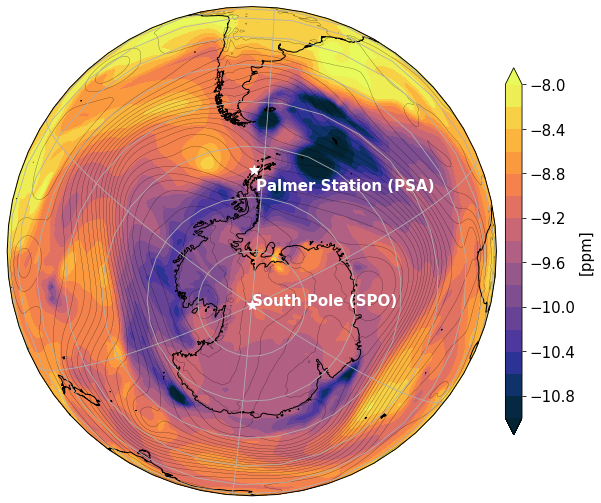

In [29]:
import cartopy.util as cutil 
import plot_tools
import cmocean
import matplotlib.patheffects as path_effects


fig = plt.figure(figsize=(16,9))

prj = ccrs.NearsidePerspective(central_latitude=-80,
                               central_longitude=295,
                               satellite_height=10000000.0*2)

#prj = ccrs.SouthPolarStereo()#central_longitude=180)
#prj = ccrs.Orthographic(210, -45)
crs_latlon = ccrs.PlateCarree()
ax = plt.axes(projection=prj)

#ax.set_extent([180,-180,-90,-35],crs=crs_latlon)
ax.set_global()


#--- plot co2
l = -10
mlon = ds.lon
mlat = ds.lat
mfield = ds.CO2_OCN.isel(lev=-1,time=l)

mfield, mlon = cutil.add_cyclic_point(mfield.values, coord=mlon.values)
levels = plot_tools.nice_levels(-11.,-8.,30,outside=False)

cf = ax.contourf(mlon,mlat,mfield,
                 cmap = cmocean.cm.thermal,
                 extend='both',
                 levels=levels,
                 transform=crs_latlon)


mlon = dsh.lon
mlat = dsh.lat
mfield = dsh.Z3.isel(plev=0,time=l) #ds.CO2.isel(lev=-1,time=-1) - ds.CO2.isel(lev=-10,time=-1)

mfield, mlon = cutil.add_cyclic_point(mfield.values, coord=mlon.values)
levels = plot_tools.nice_levels(np.min(mfield),np.max(mfield),30,outside=False)

ax.contour(mlon,mlat,mfield,
            levels=levels,
            colors='k',
            linewidths=0.2,
            transform=crs_latlon)

ax.coastlines('50m')
ax.gridlines()

#--plot flights
#color = colorbrewer.qualitative8y()
#ax.plot(lon,lat,'.',
#        transform=ccrs.PlateCarree(),
#        color=color[0],
#        markersize=4,
#        linewidth=0.5)



for name,lonlat in waypoints.items():    
    ax.plot(lonlat[0],lonlat[1],'*', markersize=10, transform=ccrs.PlateCarree(), color='w')
    if 'Palmer' in name:
        t = ax.text(lonlat[0]+1, lonlat[1]-4, name, fontweight='bold', fontsize=15,transform=ccrs.PlateCarree(),color='w')
    elif 'South Pole' in name:
        t = ax.text(lonlat[0]+1, lonlat[1], name, fontweight='bold', fontsize=15, transform=ccrs.PlateCarree(),color='w')
    else:
        continue

#cbax = fig.add_axes([0.87,0.1,0.03,0.75])
cb = plt.colorbar(cf,shrink=0.75,pad=0.01)#,cax=cbax)
cb.set_label('[ppm]',fontsize=15)
cb.ax.tick_params(labelsize=15) 
plt.savefig(os.path.join(diro['fig'], 'psa-spo-locator-xy-co2-Z3_500mb.pdf'), dpi=300, 
            bbox_inches='tight', transparent=True)